In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from itertools import product
from sklearn import metrics
import seaborn as sns

# We are asking you to predict total sales for every product and store in the next month

In [2]:
df3 = pd.read_csv('sales_train.csv.gz 2.csv', parse_dates = ['date'], compression='gzip')

df1 = pd.read_csv('item_categories.csv')
df2 = pd.read_csv('items.csv')
df4 = pd.read_csv('shops.csv')

test1 = pd.read_csv('test.csv')
test = pd.read_csv('sample_submission.csv')

In [3]:
df3

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-09-10,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [3]:
items = df1.merge(df2, on='item_category_id')
df = df3.merge(items, on='item_id').merge(df4, on='shop_id')

most_popular_items = df.groupby('item_name')['item_cnt_day'].count().reset_index().sort_values(by='item_cnt_day', ascending=False)
biggest_item = df.groupby('item_name')['item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day', ascending=False)
biggest_sales = df.groupby('item_category_name')['item_price'].agg({'sum', 'count'}).reset_index().sort_values(by='sum', ascending=False)
num_items = items.groupby('item_category_name')['item_id'].count().reset_index().sort_values(by='item_id', ascending=False)

In [4]:
df['city'] = df['shop_name'].apply(lambda x: x.split(' ')[0])
df['is_tc'] = df['shop_name'].apply(lambda x: 1 if 'ТЦ' in x else (1 if 'ТРЦ' in x else (1 if 'ТРК' in x else 0 )))
df['is_weekday'] = df['date'].loc[:10].apply(lambda x: 1 if pd.datetime.isoweekday(x) in [6,7] else 0)
df['year'] = df['date'].apply(lambda x: str(x)[:4])
df['month'] = df['date'].apply(lambda x: str(x)[5:7])
df['ym'] = df['date'].apply(lambda x: str(x)[:7])
df['quater'] = np.where(df['month'].isin(['01', '02', '03']),'1',
               np.where(df['month'].isin(['04', '05', '06']),'2',
               np.where(df['month'].isin(['07', '08', '09']),'3', '4' )))

df['category'] = df['item_category_name'].apply(lambda x: x.split(' ')[0])#.unique()
df['game_ecosystem'] = df['item_category_name'].apply(lambda x: 
                                                     'ps2' if 'PS2' in x else
                                                      ('ps3' if 'PS3' in x else
                                                       ('ps4' if 'PS4' in x else
                                                        ('psv' if 'PSVita' in x else
                                                         ('PSP' if 'PSP' in x else
                                                          ('XBOX 360' if 'XBOX 360' in x else
                                                           ('XBOX ONE' if 'XBOX ONE' in x else
                                                            ('PC' if 'PC' in x else 'other'))))))))
df = df.sort_values(by=['date', 'city', 'shop_id', 'item_price'])

In [5]:
df['revenue'] = df['item_price'] * df['item_cnt_day']

shop_id item_cnt_day


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


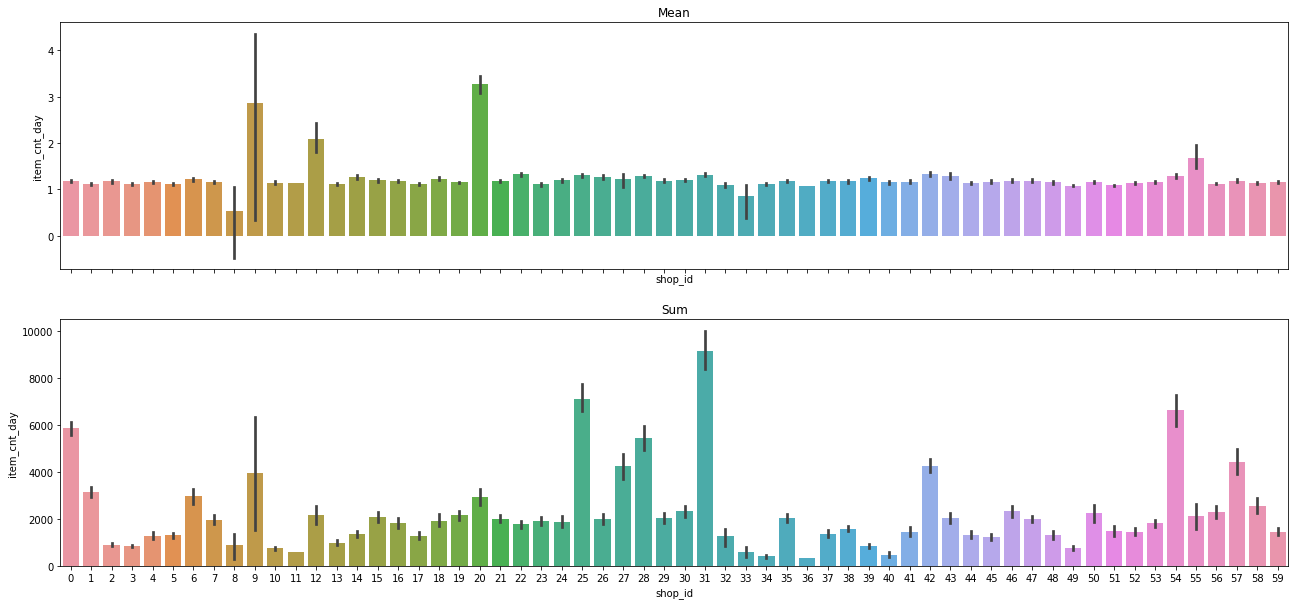

shop_id revenue


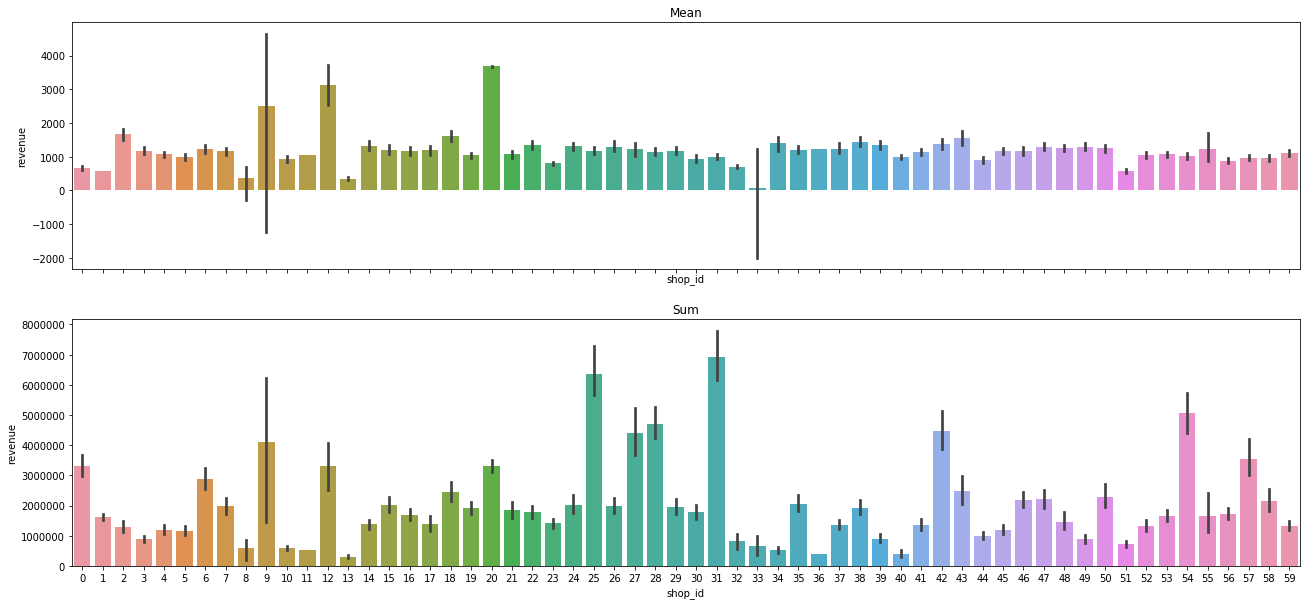

item_category_id item_cnt_day


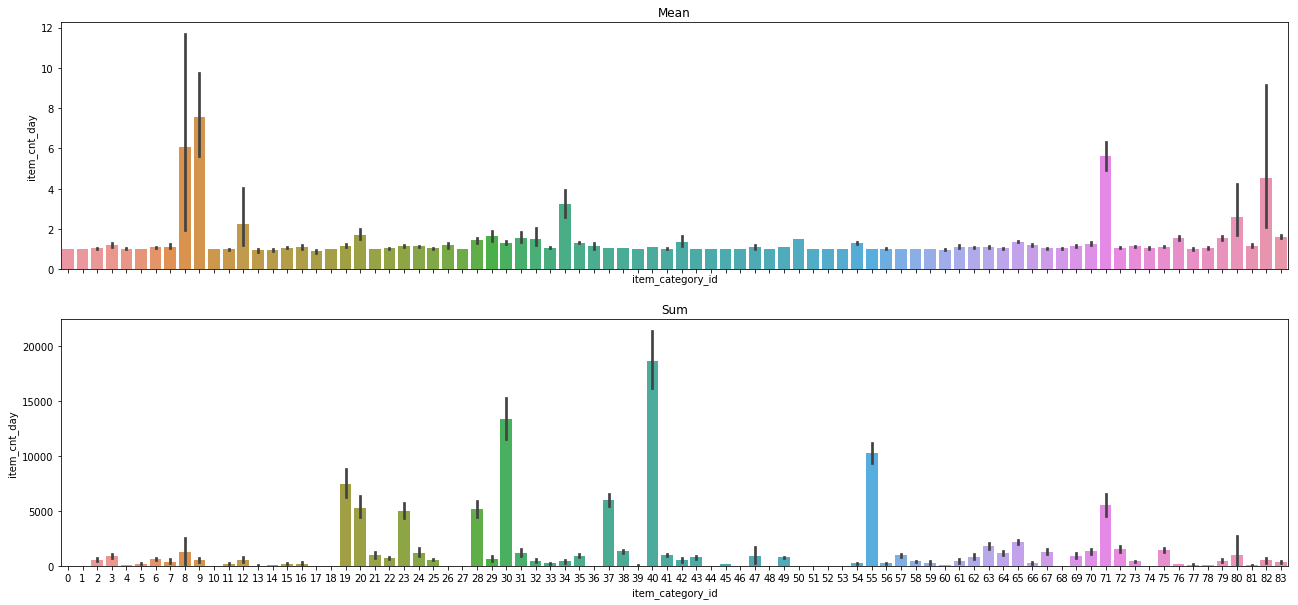

item_category_id revenue


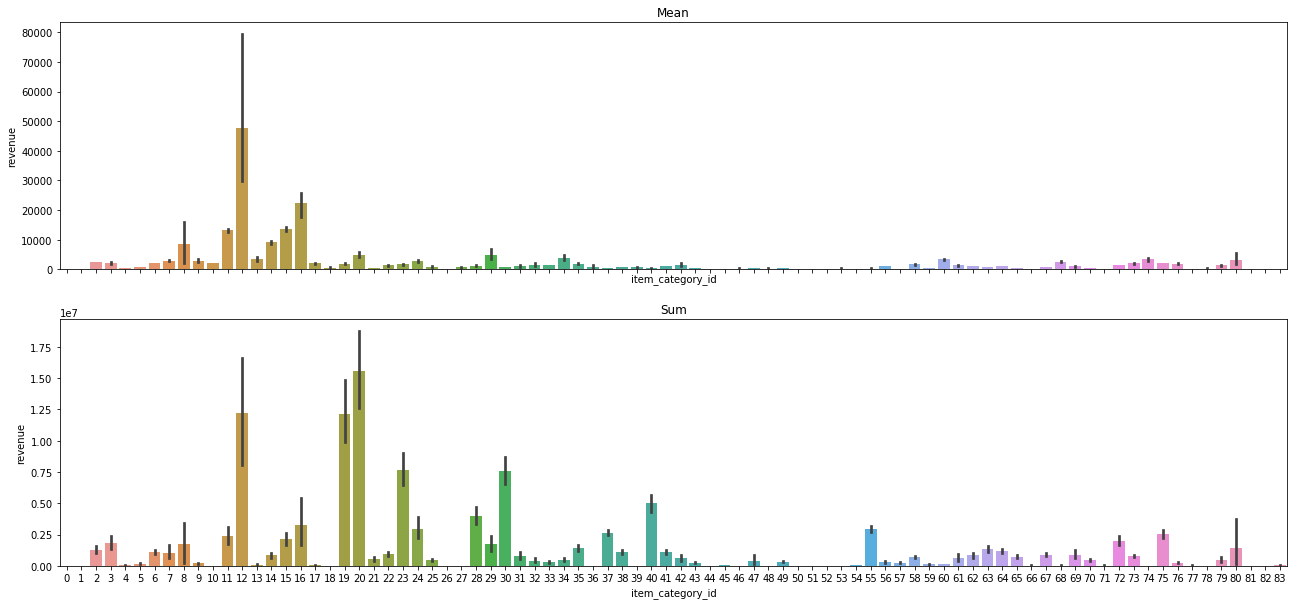

city item_cnt_day


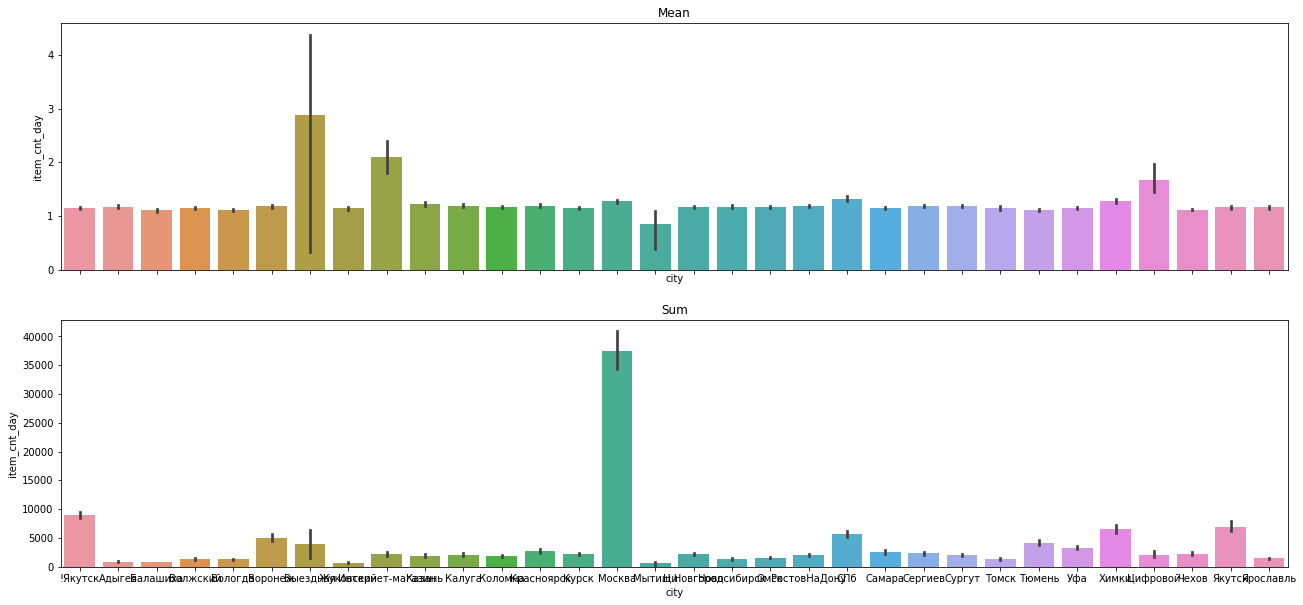

city revenue


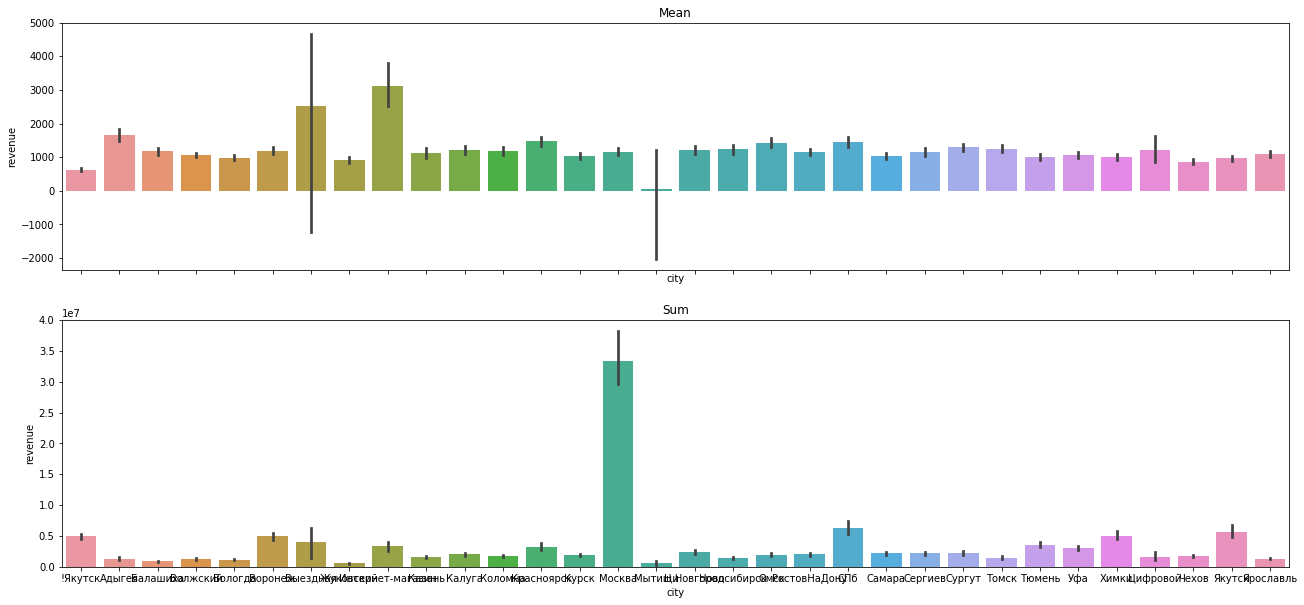

category item_cnt_day


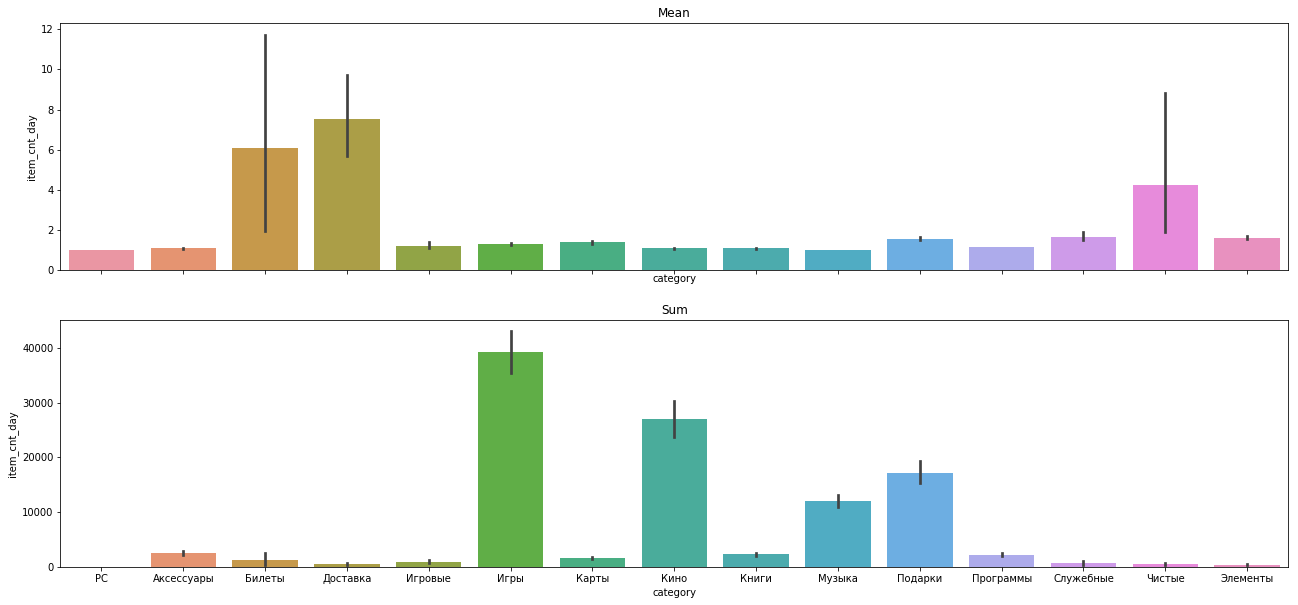

category revenue


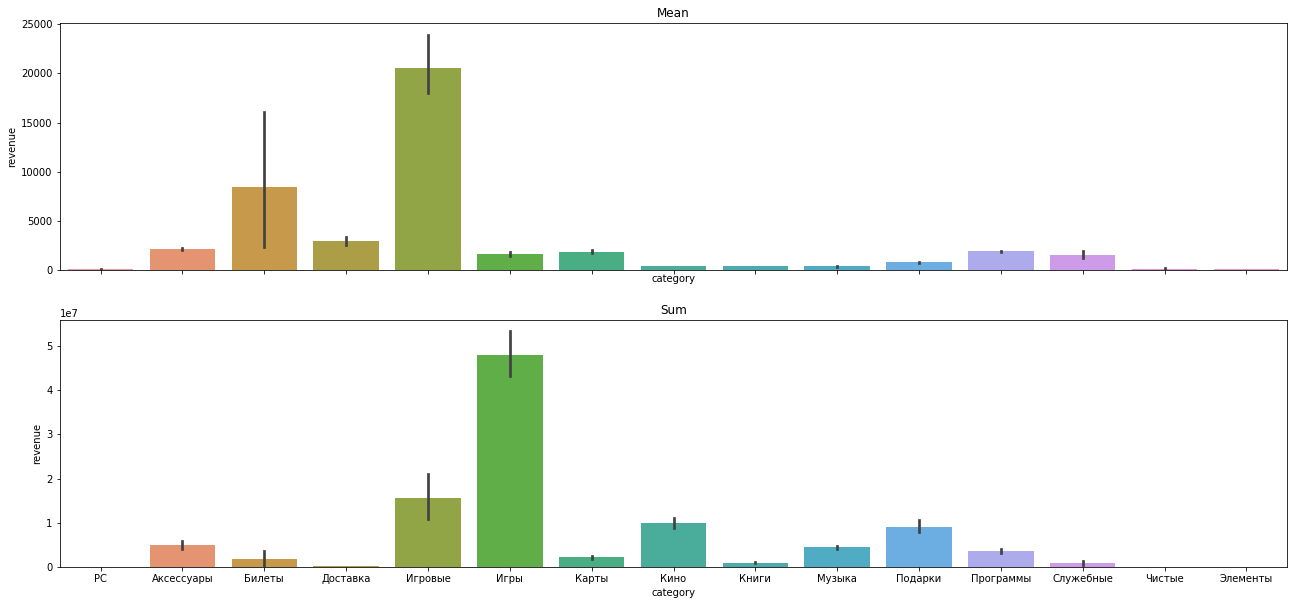

In [8]:
for col in ['shop_id', 'item_category_id', 'city', 'category']:
    for money in ['item_cnt_day', 'revenue']:
        print(col, money)
        index_cols = [col, 'date_block_num']
        sum_ = df.groupby(index_cols, as_index=False).agg({money:'sum'})
        mean_ = df.groupby(index_cols, as_index=False).agg({money:'mean'})
        f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
        sns.barplot(x=col, y=money, data=mean_, ax=axes[0]).set_title("Mean")
        sns.barplot(x=col, y=money, data=sum_, ax=axes[1]).set_title("Sum")
        plt.show()

Text(0.5,1,'Number of items sold in each month')

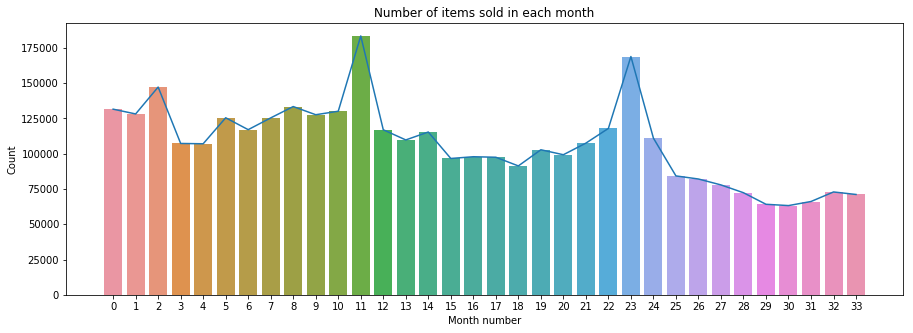

In [17]:
item_cnt_month = df.groupby('date_block_num')['item_cnt_day'].sum()

plt.figure(figsize=(15,5))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

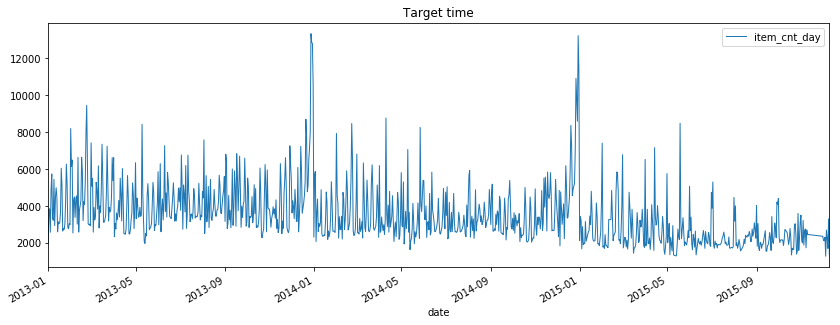

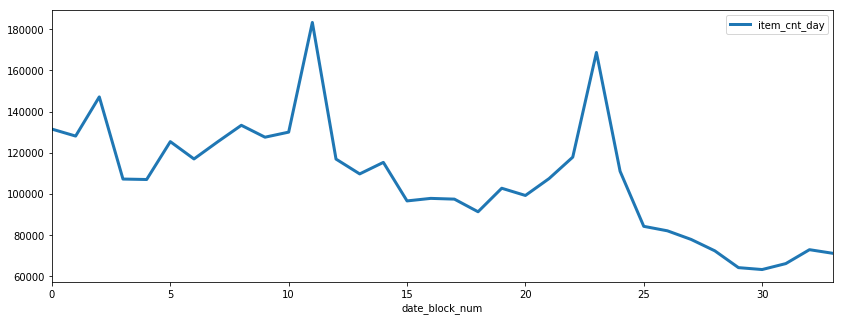

In [9]:
df['date'] = pd.to_datetime(df['date'], format="%d.%m.%Y")
df.groupby('date').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), title='Target time', lw=1.0)
df.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), lw=3.0)
plt.show()

### Additional info about population in cities 

##### Download additional info about population in russian cities

In [53]:
cities = pd.read_excel('cities.xlsx')
cities.head(3)

,city,2013y,2014y,2015y
0,Адыгея,444000.0,446000.0,449000.0
1,Москва,11613000.0,11980000.0,12108000.0
2,Тюмень,610000.0,634000.0,680000.0


In [8]:
cnt = df.groupby(['year', 'city', 'item_category_name'])['item_price'].agg({'sum'}).reset_index()

y2013 = cnt[cnt['year'] == '2013'].drop('year', axis=1)
y2014 = cnt[cnt['year'] == '2014'].drop('year', axis=1)
y2015 = cnt[cnt['year'] == '2015'].drop('year', axis=1)

cnt = y2013.merge(y2014, on=['city', 'item_category_name'], how='outer')\
                .merge(y2015, on=['city', 'item_category_name'], how='outer')

cnt.columns = ['city', 'item_category_name', 'cnt13', 'cnt14', 'cnt15']

market_share = cnt.merge(cities, on='city', how='left')
market_share['share13'] = market_share['cnt13'] / market_share['2013y']
market_share['share14'] = market_share['cnt14'] / market_share['2014y']
market_share['share15'] = market_share['cnt15'] / market_share['2015y']
market_share = market_share.fillna(0)

market_share.head(10)

,city,item_category_name,cnt13,cnt14,cnt15,2013y,2014y,2015y,share13,share14,share15
0,!Якутск,PC - Гарнитуры/Наушники,93.0,0.0,0.0,278000.0,286000.0,294000.0,0.000335,0.0,0.0
1,!Якутск,Аксессуары - PS2,283.0,0.0,0.0,278000.0,286000.0,294000.0,0.001018,0.0,0.0
2,!Якутск,Аксессуары - PS3,276579.0,0.0,0.0,278000.0,286000.0,294000.0,0.994888,0.0,0.0
3,!Якутск,Аксессуары - PS4,12100.0,0.0,0.0,278000.0,286000.0,294000.0,0.043525,0.0,0.0
4,!Якутск,Аксессуары - PSP,36429.0,0.0,0.0,278000.0,286000.0,294000.0,0.131040,0.0,0.0
5,!Якутск,Аксессуары - PSVita,63956.0,0.0,0.0,278000.0,286000.0,294000.0,0.230058,0.0,0.0
6,!Якутск,Аксессуары - XBOX 360,282375.0,0.0,0.0,278000.0,286000.0,294000.0,1.015737,0.0,0.0
7,!Якутск,Игровые консоли - PS3,722742.0,0.0,0.0,278000.0,286000.0,294000.0,2.599791,0.0,0.0
8,!Якутск,Игровые консоли - PSP,87284.0,0.0,0.0,278000.0,286000.0,294000.0,0.313971,0.0,0.0
9,!Якутск,Игровые консоли - PSVita,217979.0,0.0,0.0,278000.0,286000.0,294000.0,0.784097,0.0,0.0


### City classification by price

In [9]:
median_price = df.groupby('item_name')['item_price'].median().reset_index()
city_median_price = df.groupby(['city', 'item_name'])['item_price'].median().reset_index()
sold = df.groupby(['city', 'item_name'])['item_cnt_day'].sum().reset_index()
price = city_median_price.merge(median_price, on='item_name', how='inner')
price = price.merge(sold, on=['city', 'item_name'], how='inner')
price.columns = 'city', 'item_name', 'median_item_price', 'city_price', 'item_cnt_day'
price['expencity'] = price['city_price'] / price['median_item_price']
price['weighted'] = price['expencity'] * price['item_cnt_day']

price_ranking = price.groupby('city')['weighted'].agg({'sum', 'mean'}).reset_index()
price_ranking['sum'] = price_ranking['sum'] / 100000
price_ranking.columns = 'city', 'weighted_sum', 'weighted_mean'

price_ranking.sort_values(by='weighted_sum', ascending=False).head(5)

,city,weighted_sum,weighted_mean
14,Москва,12.698752,71.590661
30,Якутск,2.272332,17.841805
20,СПб,2.016134,16.107162
27,Химки,1.841223,13.281564
5,Воронеж,1.773653,13.707803


### Shares of expensive and cheap goods in each category

In [10]:
p25 = df.groupby('category')['item_price'].describe()['25%'].reset_index()
p75 = df.groupby('category')['item_price'].describe()['75%'].reset_index()
df = df.merge(p25.merge(p75))
df['price_categotry'] = np.where(df['item_price'] < df['25%'], 'low',
                        np.where(df['item_price'] > df['75%'], 'high', 'mid'))
a = []
for year in df['year'].unique().tolist():
    dfyear = df[df['year'] == year]
    price_cats = dfyear.groupby(['city' ,'category', 'price_categotry'])['item_cnt_day'].sum().reset_index()
    tot = price_cats.groupby(['city', 'category'])['item_cnt_day'].sum().reset_index()
    tot.columns = 'city', 'category', 'tot'
    price_cats = price_cats.merge(tot, on=['city', 'category'])
    price_cats['share'] = price_cats['item_cnt_day'] / price_cats['tot']
    a.append(price_cats)

ap = a[0].merge(a[1], on=['city', 'category', 'price_categotry'],
                how='outer').merge(a[2], on=['city', 'category', 'price_categotry'], how='outer')
ap = ap.fillna(0)
ap.head(5)

,city,category,price_categotry,item_cnt_day_x,tot_x,share_x,item_cnt_day_y,tot_y,share_y,item_cnt_day,tot,share
0,!Якутск,PC,mid,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,!Якутск,Аксессуары,high,51.0,605.0,0.084298,0.0,0.0,0.0,0.0,0.0,0.0
2,!Якутск,Аксессуары,low,245.0,605.0,0.404959,0.0,0.0,0.0,0.0,0.0,0.0
3,!Якутск,Аксессуары,mid,309.0,605.0,0.510744,0.0,0.0,0.0,0.0,0.0,0.0
4,!Якутск,Игровые,low,54.0,159.0,0.339623,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
pt = ap.pivot_table(values = ['share', 'item_cnt_day_x' ], index =['city', 'category'], columns ='price_categotry')

pt = pt.reset_index()
pt.columns = ['city', 'category', 'item_cnt_day_x_h', 'item_cnt_day_x_l', 
                'item_cnt_day_x_m', 'share_h', 'share_l', 'share_m']

pt.head()

### Price elasticity

In [13]:
pe = df[df['ym'] < '2015-11'].pivot_table(values='item_cnt_day', index='city',
                                                      columns='ym', aggfunc='sum')

price_volatility = df.groupby(['ym', 'shop_name', 'item_name'])['item_price'].std().reset_index()
price_volatility

price_volatility = df.groupby(['ym', 'shop_name', 'item_name'])['item_price'].std().reset_index()

price_volatility_by_shop = price_volatility.fillna(0).groupby(['ym', 'shop_name'])['item_price'].std()

mean_monthly_price = df.groupby(['ym', 'shop_name', 'item_name'])['item_price'].mean().reset_index()
purch_per_month = df.groupby(['ym', 'shop_name', 'item_name'])['item_cnt_day'].sum().reset_index()

price_cnt = mean_monthly_price.merge(purch_per_month)

price_cnt['price-1'] = price_cnt.groupby(['shop_name', 'item_name'])['item_price'].shift(periods=1)
price_cnt['price-3'] = price_cnt.groupby(['shop_name', 'item_name'])['item_price'].shift(periods=1)

price_cnt['cnt-1'] = price_cnt.groupby(['shop_name', 'item_name'])['item_cnt_day'].shift(periods=1)
price_cnt['cnt-3'] = price_cnt.groupby(['shop_name', 'item_name'])['item_cnt_day'].shift(periods=1)

price_cnt['price_elastisity'] = ((price_cnt['item_price'] - price_cnt['price-1']) / price_cnt['price-1'] ) /\
                                   ( (price_cnt['item_cnt_day'] - price_cnt['cnt-1']) / price_cnt['cnt-1'])

price_cnt = price_cnt.replace([np.inf, -np.inf], np.nan)
price_cnt = price_cnt.groupby(['shop_name', 'item_name'])['price_elastisity'].agg({'sum', 'mean'}).reset_index()
price_cnt.sort_values(by='sum')

,shop_name,item_name,sum,mean
179137,"Москва ТЦ ""МЕГА Белая Дача II""","Titanfall [Xbox 360, русская версия]",-30283.123119,-3028.312312
122878,"Москва МТРЦ ""Афи Молл""","Battlefield 4 [PS3, русская версия]",-11855.510960,-1317.278996
190231,"Москва ТЦ ""МЕГА Теплый Стан"" II","Titanfall [Xbox 360, русская версия]",-10388.534483,-944.412226
107781,"Красноярск ТЦ ""Июнь""",Змей ЯШКА антистресс 33 см.,-10198.000000,-10198.000000
259884,"Омск ТЦ ""Мега""",Змей МАКС антистресс 33 см.,-10198.000000,-10198.000000
...,...,...,...,...
42924,"Воронеж ТРЦ ""Максимир""","Battlefield 4 [Xbox 360, русская версия]",5504.150137,500.377285
355730,"Уфа ТК ""Центральный""","Titanfall [PC, русская версия]",5992.590775,460.968521
88922,"Коломна ТЦ ""Рио""","Battlefield 4 [Xbox 360, русская версия]",6082.046553,868.863793
42922,"Воронеж ТРЦ ""Максимир""","Battlefield 4 [PS3, русская версия]",6708.840575,516.064660


### ABC analysis for every shop

In [56]:
abc = df.groupby(['year', 'shop_id', 'item_category_name'])['revenue'].sum().reset_index()
abc = abc.pivot_table(values='revenue', index=['shop_id', 'item_category_name'] , columns='year').reset_index()

names_to_del = []
for year in ['2013', '2014', '2015']:
    abc = abc.sort_values(by=['shop_id', year], ascending=[True, False])
    abc['cumsum'+str(year)] = abc.groupby('shop_id')[year].cumsum()
    sum_shop = abc.groupby('shop_id')[year].sum().reset_index()
    sum_shop.columns = 'shop_id', 'sum'+str(year)
    abc = abc.merge(sum_shop, on='shop_id')
    abc['share' + str(year)] = abc['cumsum'+str(year)] / abc['sum'+str(year)]
    abc['abc' + year] = np.where(abc['share' + str(year)] < 0.8, 'A',
                         (np.where(abc['share' + str(year)] < 0.95, 'B', 
                            (np.where(abc['share' + str(year)].isna(), None, 'C')))))
    
    names_to_del.append(['share' + str(year), 'cumsum'+str(year), 'sum'+str(year) ])
    
a = []
for i in range(len(names_to_del)):
    for k in names_to_del[i]:
        a.append(k)
        
abc = abc.drop(a, axis=1)

In [15]:
abc[(abc['abc2013'] == 'A') & (abc['abc2014'] == 'A') & (abc['abc2015'] == 'A')].head(5)

,shop_id,item_category_name,2013,2014,2015,abc2013,abc2014,abc2015
89,2,Игры - PS4,337874.70,3858244.70,3298535.0,A,A,A
90,2,Игры - PS3,3087091.79,2741616.40,1242912.2,A,A,A
91,2,Игры PC - Стандартные издания,898146.89,975032.14,949799.5,A,A,A
92,2,Игры - XBOX 360,1467907.25,1861883.30,883647.6,A,A,A
94,2,Игры PC - Дополнительные издания,424852.16,656487.46,509732.5,A,A,A


####  abc ecosystems

In [16]:
abc = df.groupby(['year', 'shop_id', 'game_ecosystem'])['revenue'].sum().reset_index()
abc = abc.pivot_table(values='revenue', index=['shop_id', 'game_ecosystem'] , columns='year').reset_index()

names_to_del = []
for year in ['2013', '2014', '2015']:
    abc = abc.sort_values(by=['shop_id', year], ascending=[True, False])
    abc['cumsum'+str(year)] = abc.groupby('shop_id')[year].cumsum()
    sum_shop = abc.groupby('shop_id')[year].sum().reset_index()
    sum_shop.columns = 'shop_id', 'sum'+str(year)
    abc = abc.merge(sum_shop, on='shop_id')
    abc['share' + str(year)] = abc['cumsum'+str(year)] / abc['sum'+str(year)]
    abc['abc' + year] = np.where(abc['share' + str(year)] < 0.8, 'A',
                         (np.where(abc['share' + str(year)] < 0.95, 'B', 
                            (np.where(abc['share' + str(year)].isna(), None, 'C')))))
    
    names_to_del.append(['share' + str(year), 'cumsum'+str(year), 'sum'+str(year) ])
    
a = []
for i in range(len(names_to_del)):
    for k in names_to_del[i]:
        a.append(k)
        
abc1 = abc.drop(a, axis=1)

In [17]:
abc1[(abc1['abc2013'] == 'A') & (abc1['abc2014'] == 'A') & (abc1['abc2015'] == 'A')].head(5)

,shop_id,game_ecosystem,2013,2014,2015,abc2013,abc2014,abc2015
15,2,ps4,2.196047e+06,7.584787e+06,4108970.00,A,A,A
24,3,other,1.871569e+06,2.372460e+06,1999163.40,A,A,A
25,3,ps3,2.145283e+06,2.113067e+06,1143078.85,A,A,A
31,4,other,3.543997e+06,3.496346e+06,2647588.70,A,A,A
33,4,PC,3.523295e+06,2.697370e+06,1418588.60,A,A,A


### BCG Matrix

#### bcg categories

In [55]:
bcg = df[df['ym'] < '2015-11'].pivot_table(values='item_cnt_day', index='category',
                                                      columns='ym', aggfunc='sum')

bcg.drop(['2013-11', '2013-12', '2014-11', '2014-12'], axis=1, inplace=True)

y2013, y2014, y2015 = [], [], []
for i in bcg.columns:
    if '2013' in i:
        y2013.append(i)
    if '2014' in i:
        y2014.append(i)
    if '2015' in i:
        y2015.append(i)

bcg['y2013'] = bcg[y2013].sum(axis=1)
bcg['y2014'] = bcg[y2014].sum(axis=1)
bcg['y2015'] = bcg[y2015].sum(axis=1)

bcg['y2013'] = np.where(bcg['y2013']==0, 1, bcg['y2013'])

bcg['3y cagr'] = (((bcg['y2015'] / bcg['y2013']) ** (1/5)) - 1) * 100
bcg['2y cagr'] = (((bcg['y2015'] / bcg['y2014']) ** (1/5)) - 1) * 100

bcg = bcg.sort_values(by=['2y cagr'], ascending=False)
bcg = bcg.replace(np.inf, np.nan)

total_market = bcg[y2015].sum().sum()

bcg['Share 2019'] = bcg['y2015'] / total_market * 100
bcg = bcg.sort_values(by=['Share 2019'], ascending=False)

bcg = bcg.dropna(subset=['2y cagr'])
bcg['bcg'] = np.where((bcg['Share 2019'] <= 3) & (bcg['2y cagr'] <= -4), 'dogs',
                        np.where((bcg['Share 2019'] > 3) & (bcg['2y cagr'] > -4), 'stars',
                        np.where((bcg['Share 2019'] <= 3) & (bcg['2y cagr'] >= -4), 'quastions',
                        np.where((bcg['Share 2019'] > 3) & (bcg['2y cagr'] < -4), 'cows', 0))))

dogs         5
quastions    4
cows         4
stars        1
Name: bcg, dtype: int64

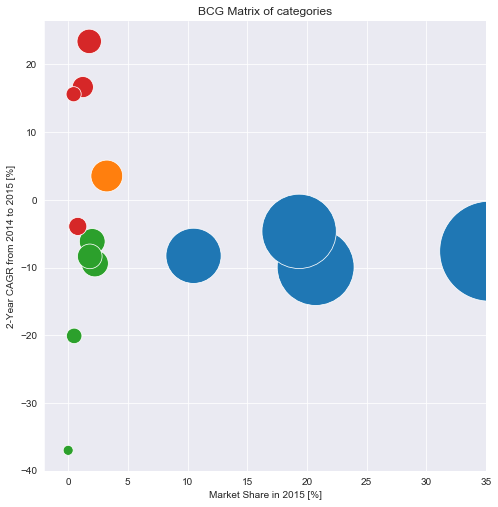

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
ax = sns.relplot(x='Share 2019',  y='2y cagr', size='y2015', data=bcg, 
                 sizes=(100,10000), legend=False, hue='bcg', height=7)
ax.set(xlim=(-2, 35))
plt.title('BCG Matrix of categories')
plt.xlabel('Market Share in 2015 [%]')
plt.ylabel('2-Year CAGR from 2014 to 2015 [%]');
bcg['bcg'].value_counts()

### bcg cities

In [20]:
bcg = df[df['ym'] < '2015-11'].pivot_table(values='item_cnt_day', index='city',
                                                      columns='ym', aggfunc='sum')

bcg.drop(['2013-11', '2013-12', '2014-11', '2014-12'], axis=1, inplace=True)

y2013, y2014, y2015 = [], [], []
for i in bcg.columns:
    if '2013' in i:
        y2013.append(i)
    if '2014' in i:
        y2014.append(i)
    if '2015' in i:
        y2015.append(i)

bcg['y2013'] = bcg[y2013].sum(axis=1)
bcg['y2014'] = bcg[y2014].sum(axis=1)
bcg['y2015'] = bcg[y2015].sum(axis=1)

bcg['y2013'] = np.where(bcg['y2013']==0, 1, bcg['y2013'])

bcg['3y cagr'] = (((bcg['y2015'] / bcg['y2013']) ** (1/5)) - 1) * 100
bcg['2y cagr'] = (((bcg['y2015'] / bcg['y2014']) ** (1/5)) - 1) * 100

bcg = bcg.sort_values(by=['2y cagr'], ascending=False)
bcg = bcg.replace(np.inf, np.nan)

total_market = bcg[y2015].sum().sum()

bcg['Share 2019'] = bcg['y2015'] / total_market * 100
bcg = bcg.sort_values(by=['Share 2019'], ascending=False)

bcg2 = bcg.dropna(subset=['2y cagr'])
bcg2['bcg'] = np.where((bcg2['Share 2019'] <= 2) & (bcg2['2y cagr'] <= -5), 'dogs',
              np.where((bcg2['Share 2019'] > 2)  & (bcg2['2y cagr'] > -5), 'stars',
              np.where((bcg2['Share 2019'] <= 2) & (bcg2['2y cagr'] >= -5), 'quastions',
              np.where((bcg2['Share 2019'] > 2)  & (bcg2['2y cagr'] < -5), 'cows', 0))))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cows         11
dogs         10
quastions     6
stars         4
Name: bcg, dtype: int64

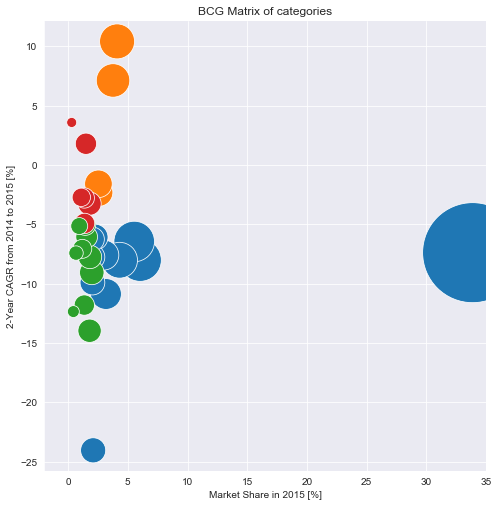

In [21]:

sns.set_style('darkgrid')
ax = sns.relplot(x='Share 2019',  y='2y cagr', size='y2015', data=bcg2, 
                 sizes=(100,10000), legend=False, hue='bcg', height=7)
ax.set(xlim=(-2, 35))
plt.title('BCG Matrix of categories')
plt.xlabel('Market Share in 2015 [%]')
plt.ylabel('2-Year CAGR from 2014 to 2015 [%]');
bcg2['bcg'].value_counts()

### Volatility

In [25]:
def linreg(X, Y):
    """
    return a,b in solution to y = ax + b such that root mean square distance between 
    trend line and original points is minimized
    """
    N = len(X)
    Sx = Sy = Sxx = Syy = Sxy = 0.0
    for x, y in zip(X, Y):
        Sx = Sx + x
        Sy = Sy + y
        Sxx = Sxx + x*x
        Syy = Syy + y*y
        Sxy = Sxy + x*y
    det = Sxx * N - Sx * Sx
    return (Sxy * N - Sy * Sx)/det, (Sxx * Sy - Sx * Sxy)/det

### by category

In [26]:
volat_city_cat = df[df['ym'] < '2015-11'].pivot_table(values='item_cnt_day', index='category',
                                                      columns='ym', aggfunc='sum')

vcct = volat_city_cat.T
intercept, trend = [], []
for cat in vcct.columns:
    x = vcct[cat].fillna(0).values
    inte, tren = linreg(range(len(x)),x)
    intercept.append(inte)
    trend.append(tren)
volat_city_cat['intercept'] = intercept
volat_city_cat['trend'] = trend
volat_city = volat_city_cat.reset_index()
volat_cat = volat_city[['category', 'intercept', 'trend']]
volat_cat.head()

ym,category,intercept,trend
0,PC,-0.011765,0.282353
1,Аксессуары,-30.178915,2967.334454
2,Билеты,30.346066,-105.857143
3,Доставка,30.085256,29.828571
4,Игровые,-14.027196,1170.566387


### by city

In [27]:
volat_city_cat = df[df['ym'] < '2015-11'].pivot_table(values='item_cnt_day', index='city',
                                                      columns='ym', aggfunc='sum')

vcct = volat_city_cat.T
intercept, trend = [], []
for cat in vcct.columns:
    x = vcct[cat].fillna(0).values
    inte, tren = linreg(range(len(x)),x)
    intercept.append(inte)
    trend.append(tren)
volat_city_cat['intercept'] = intercept
volat_city_cat['trend'] = trend
volat_city = volat_city_cat.reset_index()
volat_city = volat_city[['city', 'intercept', 'trend']]
volat_city.head()

ym,city,intercept,trend
0,!Якутск,-76.874561,1798.312605
1,Адыгея,2.813904,840.305882
2,Балашиха,-5.191444,906.600000
3,Волжский,-26.179832,1708.173109
4,Вологда,-1.578151,1262.598319


### Coefficients for caterories by months

In [42]:
tbm = df.pivot_table(values='item_cnt_day', index='category',
                                                      columns='ym', aggfunc='sum')

list_cols = tbm.columns.tolist()
coef = pd.DataFrame(index=df.category.unique().tolist()).reset_index()
coef.columns = ['category']

for i in range(12):
    month = pd.DataFrame([tbm[list_cols[i]].T, tbm[list_cols[i + 12]].T,  tbm[list_cols[i + 24]].T])
    month['sum'] = month.fillna(0).sum(axis=1)
    month = month.T
    month['m1413_' + str(i + 1)] = month[list_cols[i + 12]] / month[list_cols[i]]
    month['m1513_' + str(i + 1)] = month[list_cols[i + 24]] / month[list_cols[i]]
    month['m1514_' + str(i + 1)] = month[list_cols[i + 24]] / month[list_cols[i + 12]]
    month = month[['m1413_' + str(i + 1), 'm1513_' + str(i + 1), 'm1514_' + str(i + 1)]]
    month = month.reset_index()             
    coef = coef.merge(month, on='category')

coef['coef'] = coef[['category', 'm1514_1', 'm1514_2', 'm1514_3', 'm1514_4', 'm1514_5', 'm1514_6',
'm1514_7', 'm1514_8', 'm1514_9', 'm1514_10']].mean(axis=1)

coef

,category,m1413_1,m1513_1,m1514_1,m1413_2,m1513_2,m1514_2,m1413_3,m1513_3,m1514_3,...,m1413_10,m1513_10,m1514_10,m1413_11,m1513_11,m1514_11,m1413_12,m1513_12,m1514_12,coef
0,Кино,0.727644,0.445400,0.612112,0.663644,0.421585,0.635257,0.632290,0.416083,0.658057,...,0.612251,0.397895,0.649887,0.726847,0.167624,0.230619,0.723343,0.113831,0.157367,0.592802
1,Подарки,1.379038,1.363223,0.988532,1.335061,1.180099,0.883930,1.485549,1.105115,0.743910,...,1.003649,0.776974,0.774149,1.232885,0.310621,0.251946,1.145051,0.119039,0.103959,0.788778
2,Игры,0.857115,0.643825,0.751154,0.791983,0.577357,0.729002,0.746818,0.454341,0.608370,...,0.718786,0.495353,0.689151,1.131342,0.204104,0.180409,0.914679,0.107263,0.117269,0.674784
3,Аксессуары,1.100924,0.762327,0.692442,1.273455,0.676727,0.531411,1.036562,0.645274,0.622514,...,0.933202,0.609486,0.653113,0.928983,0.225720,0.242975,0.961829,0.078344,0.081453,0.615478
4,Игровые,1.316736,0.900415,0.683824,1.856749,0.611570,0.329377,1.914729,0.662016,0.345749,...,1.183673,0.423129,0.357471,0.517065,0.056741,0.109736,0.917476,0.026271,0.028634,0.333439
5,Музыка,0.780484,0.595142,0.762529,0.738820,0.541728,0.733235,0.768918,0.550469,0.715901,...,0.711355,0.464989,0.653666,0.904467,0.199403,0.220465,0.849058,0.122719,0.144536,0.651036
6,Служебные,1.659259,7.703704,4.642857,2.109091,7.745455,3.672414,0.938053,4.641593,4.948113,...,12.968254,9.952381,0.767442,20.061538,5.615385,0.279908,18.954023,3.850575,0.203153,3.000547
7,Программы,0.721460,0.499562,0.692432,0.639585,0.431288,0.674324,0.617130,0.424844,0.688419,...,0.685141,0.436926,0.637717,0.742297,0.169818,0.228774,0.762242,0.138589,0.181818,0.644828
8,Книги,0.778643,0.678161,0.870952,0.804041,0.740374,0.920816,0.757044,0.822539,1.086515,...,0.828246,1.686105,2.035754,0.826507,0.390704,0.472717,0.741532,0.223490,0.301390,1.205768
9,Чистые,0.071371,0.040552,0.568182,0.061154,NaN,NaN,0.084095,0.000914,0.010870,...,0.047782,NaN,NaN,0.060543,NaN,NaN,0.026608,NaN,NaN,0.289526


### Creating TSNE features for categories

In [47]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(coef[coef.columns[1:-1]].fillna(0))

cat_tsne = pd.DataFrame(X_embedded, index=coef['category']).reset_index()
cat_tsne['coef'] = coef['coef']
cat_tsne.columns = 'category', 'cat_tsne_1', 'cat_tsne_2', 'cat_coef'
cat_tsne.head()

,category,cat_tsne_1,cat_tsne_2,cat_coef
0,Кино,-287.111359,-780.955139,0.592802
1,Подарки,-186.973282,-398.410675,0.788778
2,Игры,-374.344421,-80.017181,0.674784
3,Аксессуары,163.454041,-645.948792,0.615478
4,Игровые,451.956848,-354.274139,0.333439


###  Coefficients for city by months

In [28]:
tbm = df.pivot_table(values='item_cnt_day', index='city',
                                                      columns='ym', aggfunc='sum')

list_cols = tbm.columns.tolist()
coef2 = pd.DataFrame(index=df.city.unique().tolist()).reset_index()
coef2.columns = ['city']

for i in range(12):
    month = pd.DataFrame([tbm[list_cols[i]].T, tbm[list_cols[i + 12]].T,  tbm[list_cols[i + 24]].T])
    month['sum'] = month.fillna(0).sum(axis=1)
    month = month.T
    month['m1413_' + str(i + 1)] = month[list_cols[i + 12]] / month[list_cols[i]]
    month['m1513_' + str(i + 1)] = month[list_cols[i + 24]] / month[list_cols[i]]
    month['m1514_' + str(i + 1)] = month[list_cols[i + 24]] / month[list_cols[i + 12]]
    month = month[['m1413_' + str(i + 1), 'm1513_' + str(i + 1), 'm1514_' + str(i + 1)]]
    month = month.reset_index()             
    coef2 = coef2.merge(month, on='city')

coef2['coef'] = coef2[['city', 'm1514_1', 'm1514_2', 'm1514_3', 'm1514_4', 'm1514_5', 'm1514_6',
'm1514_7', 'm1514_8', 'm1514_9', 'm1514_10']].mean(axis=1)

coef2.head()

,city,m1413_1,m1513_1,m1514_1,m1413_2,m1513_2,m1514_2,m1413_3,m1513_3,m1514_3,...,m1413_10,m1513_10,m1514_10,m1413_11,m1513_11,m1514_11,m1413_12,m1513_12,m1514_12,coef
0,Адыгея,0.955882,0.994652,1.040559,1.220222,1.277008,1.046538,1.198538,0.942753,0.786585,...,1.094268,0.937580,0.856810,1.449204,0.323133,0.222973,1.433005,0.156699,0.109350,0.879063
1,Воронеж,0.767345,0.524756,0.683859,0.710752,0.485941,0.683700,0.636160,0.415478,0.653104,...,0.672101,0.475132,0.706935,0.931149,0.177295,0.190405,0.814871,0.099610,0.122240,0.658752
2,Казань,0.821853,0.351940,0.428227,0.702353,0.342994,0.488350,0.663100,0.295071,0.444988,...,0.471429,0.390873,0.829125,0.732879,0.126151,0.172131,0.580261,0.079410,0.136852,0.553148
3,Калуга,0.922652,0.597110,0.647167,0.798621,0.515602,0.645616,0.716830,0.501636,0.699797,...,0.649151,0.482813,0.743761,0.945500,0.171759,0.181659,0.673898,0.132280,0.196291,0.673663
4,Красноярск,1.082545,0.501818,0.463554,0.874931,0.388213,0.443707,0.862469,0.373654,0.433237,...,0.584818,0.332263,0.568148,0.813799,0.144630,0.177723,0.667781,0.071089,0.106456,0.476135


### Creating TSNE features for cities

In [48]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(coef2[coef2.columns[1:-1]].fillna(0))

citi_tsne = pd.DataFrame(X_embedded, index=coef2['city']).reset_index()
citi_tsne['coef'] = coef2['coef']
citi_tsne.columns = 'city', 'city_tsne_1', 'city_tsne_2', 'city_coef'
citi_tsne.head()

,city,city_tsne_1,city_tsne_2,city_coef
0,Адыгея,44.890167,0.165221,0.879063
1,Воронеж,-94.409492,-94.738304,0.658752
2,Казань,11.896095,35.510094,0.553148
3,Калуга,-11.180707,119.135048,0.673663
4,Красноярск,25.624502,83.182327,0.476135


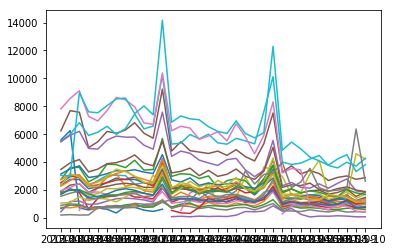

In [325]:
del df2

In [326]:
import gc
gc.collect()

0

### Stack all dataset 

In [31]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')

In [37]:
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split(' ')[0])#.unique()
shops['city'] = shops['shop_name'].apply(lambda x: x.split(' ')[0])

In [39]:
shops = shops.drop('shop_name', axis=1)

In [45]:
ms = market_share.merge(item_categories)
ms = ms.merge(shops)

In [152]:
cities = ms.merge(pr).merge(price_ranking).merge(pt).\
            merge(abc, how='right').merge(bcg).merge(volat_cat).merge(cat_tsne).merge(city_tsne).\
            merge(volat_city, on=['city', 'shop_id'])

In [110]:
cities.columns

Index(['city', 'item_category_name', 'cnt13', 'cnt14', 'cnt15', '2013y',
       '2014y', '2015y', 'share13', 'share14', 'share15', 'item_category_id',
       'category', 'shop_id', 'weighted_sum', 'weighted_mean',
       'item_cnt_day_x_h', 'item_cnt_day_x_l', 'item_cnt_day_x_m', 'share_h',
       'share_l', 'share_m', '2013', '2014', '2015', 'abc2013', 'abc2014',
       'abc2015', '2y cagr', 'Share 2019', 'bcg', 'intercept_x', 'trend_x',
       'm1413_1', 'm1513_1', 'm1514_1', 'm1413_2', 'm1513_2', 'm1514_2',
       'm1413_3', 'm1513_3', 'm1514_3', 'm1413_4', 'm1513_4', 'm1514_4',
       'm1413_5', 'm1513_5', 'm1514_5', 'm1413_6', 'm1513_6', 'm1514_6',
       'm1413_7', 'm1513_7', 'm1514_7', 'm1413_8', 'm1513_8', 'm1514_8',
       'm1413_9', 'm1513_9', 'm1514_9', 'm1413_10', 'm1513_10', 'm1514_10',
       'm1413_11', 'm1513_11', 'm1514_11', 'm1413_12', 'm1513_12', 'm1514_12',
       'coef', 'intercept_y', 'trend_y'],
      dtype='object')

# Train model

### Prepare data

In [4]:
cities = pd.read_csv('ccc.csv')
df = pd.read_csv('sales_train.csv.gz 2.csv', parse_dates = ['date'], compression='gzip')

In [5]:
df = pd.merge(df, items, on='item_id', how='left')
df = df.drop('item_name', axis=1)

In [7]:
index_cols, pairs = ['shop_id', 'item_id', 'date_block_num', 'city', 'category'], []
for block_num in df['date_block_num'].unique():
    cur_shops = df.loc[df['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = df.loc[df['date_block_num'] == block_num, 'item_id'].unique()
    cur_city = df.loc[df['date_block_num'] == block_num, 'city'].unique()
    cur_category = df.loc[df['date_block_num'] == block_num, 'category'].unique()
    pairs.append(np.array([cur_shops, cur_items, cur_city, cur_category, [block_num]]))
pairs = pd.DataFrame(pairs, columns = index_cols)

In [8]:
block_stat = df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum',
                                                                       'item_price':np.mean}).reset_index()

In [9]:
block_stat = pd.merge(pairs, block_stat,on=['date_block_num', 
                                                          'shop_id', 'item_id'],how='left').fillna(0)
block_stat = pd.merge(block_stat, items, on='item_id', how='left')

In [10]:
for col in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price', np.mean, 'avg'), ('revenue', np.sum, 'sum'), 
                                           ('item_cnt_day', np.sum, 'sum'), ('item_cnt_day', np.mean, 'avg')]:
        mean_df = df.groupby([col,'date_block_num']).agg(aggregator).reset_index()[
                                                                [column_id, col, 'date_block_num']]
        mean_df.columns = [col + '_' + aggtype + '_' + column_id,col, 'date_block_num']
        block_stat = pd.merge(block_stat, mean_df, on=['date_block_num', col], how='left')

### Creating time lags

In [11]:
lag_variables  = list(block_stat.columns[7: ]) + ['item_cnt_day']
from tqdm import tqdm_notebook
for lag in tqdm_notebook([1, 2, 3]):
    df_copy = df.copy()
    df_copy.date_block_num += lag
    df_copy = df_copy[['date_block_num', 'city', 'category', 'item_id', 'shop_id'] + lag_variables]
    df_copy.columns = ['date_block_num', 'city', 'category', 'item_id', 'shop_id'] + [lag_feat + '_lag_' + str(lag)
                                                                    for lag_feat in lag_variables]
    block_stat = pd.merge(block_stat, df_copy,on=['date_block_num', 'city', 'category', 
                                                                                  'item_id', 'shop_id'], how='left')

block_stat = block_stat[block_stat['date_block_num'] > 12]
for feat in block_stat.columns:
    if 'item_cnt' in feat:
        block_stat[feat] = block_stat[feat].fillna(0)
    elif 'item_price' in feat:
        block_stat[feat] = block_stat[feat].fillna(block_stat[feat].median())
cols_to_drop = lag_variables[:-1] + ['item_price', 'item_name']
data = block_stat.drop(cols_to_drop, axis=1)

In [49]:
import gc
gc.collect()

813

#cities = pd.read_csv('ccc.csv')
data = pd.read_csv('training.csv')
data = data.merge(cities)
del data['Unnamed: 0']

#### Preprocess data

#### Feature  label encoding

In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

obj = data.dtypes[data.dtypes == object].index.tolist()
data[obj] = data[obj].fillna('0')
data = data.fillna(0)
for i in obj:
    data[i] = labelencoder.fit_transform(data[i]) 

### Train test split using  holdout

In [13]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 33]['item_cnt_month']
X_test = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_test = data[data.date_block_num == 33]['item_cnt_month']

In [16]:
import gc
gc.collect()

2641

### Preparing data for linear regression

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_test_scaled.columns = X_test.columns

# Modeling

#### Tuning parametres

In [17]:
# Optimiziing metric is RMSE

from sklearn.model_selection import GridSearchCV

param_test = {
     'max_depth': range(3,10,2),
     'min_child_weight': range(1,10,2),
     'eta': [0.2, 0.3, 0.4],
     'num_round': [500, 1000, 1500]
     'seed': [1, 5]
    } 
 
gsearch1 = GridSearchCV(estimator = xgb, param_grid = param_test1, scoring='rmse', n_jobs=-1, cv=3)
gsearch1.fit(X_train.as_matrix(), y_train.as_matrix())
print(gsearch1.best_params_)

{'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 0.5, 'eta': 0.3, 'num_round': 1000, 'seed': 1}


#### Xgboost

In [18]:
import xgboost as xgb
xgbtrain = xgb.DMatrix(X_train.values, y_train.values)

param = {'eval_metric':'rmse', 'max_depth':10, 'min_child_weight':0.5, 'eta':0.3, 'num_round':1000, 'seed':1} 
bst = xgb.train(param, xgbtrain)

In [19]:
fi = pd.DataFrame([bst.get_score()]).T

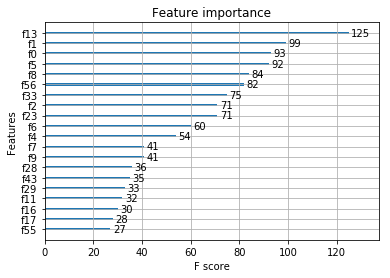

In [20]:
x=xgb.plot_importance(bst, max_num_features=20)

In [22]:
xgbpredict = xgb.DMatrix(X_test.values)
y_pred = bst.predict(xgbpredict)
y_pred_train = bst.predict(xgbtrain)

In [23]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.40264474093170244
Mean Squared Error: 8.644816029180044
Root Mean Squared Error: 2.9402068004104818


In [24]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

Mean Absolute Error: 0.38300736896338655
Mean Squared Error: 2.3083120171192197
Root Mean Squared Error: 1.5193130082768396


#### Linear regression

In [29]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
y_pred_train_ = regressor.predict(X_train_scaled)
y_pred_ = regressor.predict(X_test_scaled)

In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_)))

Mean Absolute Error: 0.4618066106119676
Mean Squared Error: 8.849501681995584
Root Mean Squared Error: 2.9748112010673187


In [32]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train_))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train_))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_)))

Mean Absolute Error: 0.4606202683322037
Mean Squared Error: 7.637308802027652
Root Mean Squared Error: 2.7635681287110785


#### Save models 

In [53]:
import pickle
file_name = "xgb_reg.pkl"
pickle.dump(bst, open(file_name, "wb"))

file_name = "linreg.pkl"
pickle.dump(regressor, open(file_name, "wb"))

file_name = "labelencoder.pkl"
pickle.dump(labelencoder, open(file_name, "wb"))

#### Blending

In [41]:
yyy = (y_pred_ + y_pred) / 2

In [42]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, yyy))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, yyy))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, yyy)))

Mean Absolute Error: 0.41120349505248077
Mean Squared Error: 8.187834497628097
Root Mean Squared Error: 2.8614392353548412


# Preparing TEST data

In [43]:
test = pd.read_csv('test.csv')
test.head()

In [44]:
test = pd.merge(test, items, on='item_id', how='left')
for lag in tqdm_notebook(lags):
    block_stat_new = block_stat.copy()
    block_stat_new.date_block_num += lag
    block_stat_new = block_stat_new[['date_block_num','shop_id','item_id'] + lag_variables]
    block_stat_new.columns = ['date_block_num','shop_id','item_id'] + 
                            [lag_feat + '_lag_' + str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, block_stat_new, on=['date_block_num', 'shop_id','item_id'], how='left')

test = test.drop(['ID', 'item_name'], axis=1)
test = test.fillna(0)
test[['shop_id', 'item_id'] + ['item_cnt_day_lag_' + str(x) for x in [1, 2, 3]]].head()
test['date_block_num'] = 34
test = test.merge(cities)

for i in obj:
    test[i] = labelencoder.transform(test[i]) 

#### prediction xgboost

In [45]:
for_pred = xgb.DMatrix(test.values)
y_pred = bst.predict(for_pred)
y_pred = pred.clip(0, 20)

#### prediction linear reg

In [46]:
y_pred_ = regressor.predict(test)
y_pred_ = y_pred_.clip(0, 20)

### blending of final sub

In [47]:
pred = (y_pred_ + y_pred) / 2

In [48]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred })
sub_df.to_csv('submission.csv',index=False)